In [22]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt



### Exploratory Analysis

In [14]:
# Merged price and return data
prices = pd.read_csv("data/cleaned/all_prices.csv", parse_dates=["Date"], index_col="Date")
log_returns = pd.read_csv("data/cleaned/log_returns.csv", parse_dates=["Date"], index_col="Date")

# Annualized metrics
days_per_year = 252
mean_daily = log_returns.mean()
vol_daily = log_returns.std()

annual_return = (np.exp(mean_daily * days_per_year) - 1) * 100  # in percent
annual_volatility = vol_daily * np.sqrt(days_per_year) * 100  # in percent
sharpe_ratio = annual_return / annual_volatility

# DataFrame summary 
summary = pd.DataFrame({
    "Annual Return (%)": annual_return.round(2),
    "Annual Volatility (%)": annual_volatility.round(2),
    "Sharpe Ratio": sharpe_ratio.round(2)
})

print("Asset Performance Summary:")
print(summary)


Asset Performance Summary:
          Annual Return (%)  Annual Volatility (%)  Sharpe Ratio
Consumer               4.51                  16.66          0.27
Manuf                  7.57                  21.13          0.36
HiTec                 21.59                  25.62          0.84
Hlth                   8.29                  18.20          0.46
btc                   29.82                  68.32          0.44
eth                   21.05                  88.06          0.24


## Covariance and Correlation

In [15]:
# 1) Log-returns
log_ret = pd.read_csv(
    "data/cleaned/log_returns.csv",
    parse_dates=["Date"], index_col="Date"
)

# 2) Daily covariance, then annualize
daily_cov = log_ret.cov()
annual_cov = daily_cov * 252   # approx. trading days per year

# 3) Correlation matrix
annual_corr = log_ret.corr()

# 4) Save or display
print("Annualized Covariance Matrix:")
print(annual_cov.round(6))

print("\nAnnualized Correlation Matrix:")
print(annual_corr.round(2))

# Save to CSV:
annual_cov.to_csv("data/cleaned/annual_cov.csv")
annual_corr.to_csv("data/cleaned/annual_corr.csv")


Annualized Covariance Matrix:
          Consumer     Manuf     HiTec      Hlth       btc       eth
Consumer  0.027756  0.028857  0.026588  0.022377  0.022111  0.031688
Manuf     0.028857  0.044644  0.041986  0.029268  0.037202  0.050891
HiTec     0.026588  0.041986  0.065636  0.035206  0.050643  0.068657
Hlth      0.022377  0.029268  0.035206  0.033107  0.026747  0.037991
btc       0.022111  0.037202  0.050643  0.026747  0.466794  0.490175
eth       0.031688  0.050891  0.068657  0.037991  0.490175  0.775390

Annualized Correlation Matrix:
          Consumer  Manuf  HiTec  Hlth   btc   eth
Consumer      1.00   0.82   0.62  0.74  0.19  0.22
Manuf         0.82   1.00   0.78  0.76  0.26  0.27
HiTec         0.62   0.78   1.00  0.76  0.29  0.30
Hlth          0.74   0.76   0.76  1.00  0.22  0.24
btc           0.19   0.26   0.29  0.22  1.00  0.81
eth           0.22   0.27   0.30  0.24  0.81  1.00


### Industry risk parity

In [16]:
# 1) Load annualized covariance for the four industries
cov = pd.read_csv("data/cleaned/annual_cov.csv", index_col=0)
# Select the sub‐matrix for industries only
assets = ["Consumer", "Manuf", "HiTec", "Hlth"]
Σ = cov.loc[assets, assets].values
n = len(assets)

# 2) Risk-parity target: equal risk contributions ρ = (1/n,...,1/n)
ρ = np.ones(n) / n

# 3) Solve for x★ by minimizing ½ xᵀΣx – ρᵀ log(x)
x = cp.Variable(n, pos=True)
obj = 0.5 * cp.quad_form(x, Σ) - ρ @ cp.log(x)
prob = cp.Problem(cp.Minimize(obj))
prob.solve()

x_star = x.value

# 4) Normalize so weights sum to 1
w = x_star / np.sum(x_star)

# 5) Report
weights = dict(zip(assets, np.round(w, 4)))
print("Industries-only Risk-Parity Weights:")
for a, wi in weights.items():
    print(f"  {a}: {wi}")


Industries-only Risk-Parity Weights:
  Consumer: 0.3032
  Manuf: 0.2269
  HiTec: 0.1986
  Hlth: 0.2713


### BackTest Industry       

In [17]:
# Load merged prices
prices = pd.read_csv("data/cleaned/all_prices.csv", parse_dates=["Date"], index_col="Date")

# Industry-only weights
weights = {
    "Consumer": 0.3032,
    "Manuf":    0.2269,
    "HiTec":    0.1986,
    "Hlth":     0.2713
}

# Extract industry prices
ind_prices = prices[list(weights.keys())]

# Daily returns
daily_ret = ind_prices.pct_change().dropna()
port_ret = daily_ret.dot(pd.Series(weights))

# Portfolio value
port_val = (1 + port_ret).cumprod()

# Metrics
T = len(port_ret)
days = 252
ann_return = (port_val[-1]**(days/T) - 1) * 100
ann_vol = port_ret.std() * np.sqrt(days) * 100
sharpe = ann_return / ann_vol
drawdown = (port_val / port_val.cummax() - 1).min() * 100

pd.DataFrame({"Value": port_val}) \
  .to_csv("data/cleaned/industry_value.csv", index_label="Date")
print("  → Written industry_value.csv")

print("Industry-Only Portfolio Backtest:")
print(f" Annual Return (%):     {ann_return:.2f}")
print(f" Annual Volatility (%): {ann_vol:.2f}")
print(f" Sharpe Ratio:          {sharpe:.2f}")
print(f" Max Drawdown (%):      {drawdown:.2f}")




  → Written industry_value.csv
Industry-Only Portfolio Backtest:
 Annual Return (%):     9.93
 Annual Volatility (%): 17.80
 Sharpe Ratio:          0.56
 Max Drawdown (%):      -31.88


/var/folders/jp/82zjtkm90vgbycmw30_2kztm0000gn/T/ipykernel_16972/2510856733.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ann_return = (port_val[-1]**(days/T) - 1) * 100


### Backtest Crypto

In [18]:
# 1) Load merged prices
prices = pd.read_csv("data/cleaned/all_prices.csv", parse_dates=["Date"], index_col="Date")

# 2) Extract crypto prices & compute daily returns
crypto = prices[["btc","eth"]]
daily_ret = crypto.pct_change().dropna()

# 3) Estimate annualized volatilities
days = 252
sigma_daily = daily_ret.std()
sigma_annual = sigma_daily * np.sqrt(days)

# 4) Compute risk‐parity weights (inverse vol)
inv_vol = 1 / sigma_annual
w = inv_vol / inv_vol.sum()
weights = w.to_dict()
print("Crypto Risk‐Parity Weights:")
for asset, wi in weights.items():
    print(f"  {asset}: {wi:.4f}")

# 5) Portfolio returns and value
port_ret = daily_ret.dot(w)
port_val = (1 + port_ret).cumprod()

# 6) Performance metrics
T = len(port_ret)
ann_return = (port_val[-1]**(days/T) - 1) * 100
ann_vol    = port_ret.std() * np.sqrt(days) * 100
sharpe     = ann_return / ann_vol
drawdown  = (port_val / port_val.cummax() - 1).min() * 100

pd.DataFrame({"Value": port_val}) \
  .to_csv("data/cleaned/crypto_value.csv", index_label="Date")
print("  → Written crypto_value.csv")


# 7) Display results
print("\nCrypto-Only Portfolio Backtest:")
print(f" Annual Return (%):     {ann_return:.2f}")
print(f" Annual Volatility (%): {ann_vol:.2f}")
print(f" Sharpe Ratio:          {sharpe:.2f}")
print(f" Max Drawdown (%):      {drawdown:.2f}")


Crypto Risk‐Parity Weights:
  btc: 0.5638
  eth: 0.4362
  → Written crypto_value.csv

Crypto-Only Portfolio Backtest:
 Annual Return (%):     30.05
 Annual Volatility (%): 72.12
 Sharpe Ratio:          0.42
 Max Drawdown (%):      -86.55


/var/folders/jp/82zjtkm90vgbycmw30_2kztm0000gn/T/ipykernel_16972/1259817024.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ann_return = (port_val[-1]**(days/T) - 1) * 100


### Combined Constrained Risk Allocation Portfolio

In [19]:
# 1) Load annualized covariance matrix
cov = pd.read_csv("data/cleaned/annual_cov.csv", index_col=0)
assets = ["Consumer","Manuf","HiTec","Hlth","btc","eth"]
Σ = cov.loc[assets, assets].values
n = len(assets)

# 2) Set parameters
rho = np.ones(n) / n       # equal risk contributions
sigma = 0.10               # 10% annualized target vol
max_crypto = 0.10          # 10% max weight for btc+eth

# 3) Step A: solve for x★
x = cp.Variable(n, pos=True)
objective = 0.5 * cp.quad_form(x, Σ) - rho @ cp.log(x)
prob = cp.Problem(cp.Minimize(objective))
prob.solve()
x_star = x.value

# 4) Step B: compute scale α
#   a) exposure cap
α1 = 1 / np.sum(x_star)
#   b) volatility cap
port_var = x_star.T @ Σ @ x_star
α2 = sigma / np.sqrt(port_var)
#   c) crypto weight cap (assets[-2:] are btc, eth)
α3 = max_crypto / np.sum(x_star[-2:])
α = min(α1, α2, α3)

# 5) Compute final weights and cash
w = α * x_star
cash = 1 - np.sum(w)
weights = dict(zip(assets, np.round(w, 4)))
weights["cash"] = round(cash,4)

# 6) Output weights
print("Combined CRA Portfolio Weights:")
for a, wi in weights.items():
    print(f"  {a}: {wi}")

# 7) Back-test
prices = pd.read_csv("data/cleaned/all_prices.csv", parse_dates=["Date"], index_col="Date")
daily_ret = prices.pct_change().dropna()

# portfolio returns (ignore cash, which has 0 return)
port_ret = daily_ret[assets].dot(w)
port_val = (1 + port_ret).cumprod()

# metrics
days = 252
T = len(port_ret)
ann_ret = (port_val[-1]**(days/T) - 1) * 100
ann_vol = port_ret.std() * np.sqrt(days) * 100
sharpe = ann_ret / ann_vol
drawdown = (port_val / port_val.cummax() - 1).min() * 100

pd.DataFrame({"Value": port_val}) \
  .to_csv("data/cleaned/cra_value.csv", index_label="Date")
print("  → Written cra_value.csv")


print("\nCombined CRA Backtest:")
print(f" Annual Return (%):     {ann_ret:.2f}")
print(f" Annual Volatility (%): {ann_vol:.2f}")
print(f" Sharpe Ratio:          {sharpe:.2f}")
print(f" Max Drawdown (%):      {drawdown:.2f}")


Combined CRA Portfolio Weights:
  Consumer: 0.1302
  Manuf: 0.0948
  HiTec: 0.0808
  Hlth: 0.1155
  btc: 0.0372
  eth: 0.0282
  cash: 0.5132
  → Written cra_value.csv

Combined CRA Backtest:
 Annual Return (%):     7.87
 Annual Volatility (%): 9.86
 Sharpe Ratio:          0.80
 Max Drawdown (%):      -16.94


/var/folders/jp/82zjtkm90vgbycmw30_2kztm0000gn/T/ipykernel_16972/2497012966.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ann_ret = (port_val[-1]**(days/T) - 1) * 100


### Dynamically Diluted 90/10 (DD 90/10) Strategy

In [20]:
# 1) Load merged prices & compute daily returns
prices = pd.read_csv("data/cleaned/all_prices.csv", parse_dates=["Date"], index_col="Date")
daily_ret = prices.pct_change().dropna()

# 2) Define base weights (90/10 split)
base_w = pd.Series({
    "Consumer": 0.90/4,
    "Manuf":    0.90/4,
    "HiTec":    0.90/4,
    "Hlth":     0.90/4,
    "btc":      0.10/2,
    "eth":      0.10/2
})

# 3) Compute base portfolio return Series
base_ret = daily_ret[base_w.index].dot(base_w)

# 4) Rolling vol estimator on base_ret (10-day EWMA)
lam = 0.5 ** (1/10)   # half-life = 10 days
vol_est = base_ret.ewm(alpha=1-lam).std() * np.sqrt(252)

# 5) Scale factor αₜ = target_vol / vol_estₜ
target_vol = 0.10
alpha = (target_vol / vol_est).clip(upper=1.0)

# 6) Portfolio returns after scaling to risk target
port_ret = base_ret * alpha

# 7) Portfolio value (start at 1)
port_val = (1 + port_ret).cumprod()

# 8) Performance metrics
days = 252
T = len(port_ret)
final_value = port_val.iloc[-1]
ann_return = (final_value ** (days/T) - 1) * 100
ann_vol    = port_ret.std() * np.sqrt(days) * 100
sharpe     = ann_return / ann_vol
drawdown   = (port_val / port_val.cummax() - 1).min() * 100

pd.DataFrame({"Value": port_val}) \
  .to_csv("data/cleaned/dd90_10_value.csv", index_label="Date")
print("  → Written dd90_10_value.csv")


# 9) Print results
print("DD 90/10 Portfolio Backtest:")
print(f" Annual Return (%):     {ann_return:.2f}")
print(f" Annual Volatility (%): {ann_vol:.2f}")
print(f" Sharpe Ratio:          {sharpe:.2f}")
print(f" Max Drawdown (%):      {drawdown:.2f}")


  → Written dd90_10_value.csv
DD 90/10 Portfolio Backtest:
 Annual Return (%):     11.75
 Annual Volatility (%): 9.59
 Sharpe Ratio:          1.23
 Max Drawdown (%):      -14.51


### Comparison Table & Plot


Performance Comparison (all start @1.0):
              Ann Return (%)  Ann Vol (%)  Sharpe  Max Drawdown (%)
Strategy                                                           
Industry RP             9.94        17.80    0.56            -31.88
Crypto RP              30.06        72.12    0.42            -86.55
Combined CRA            7.88         9.87    0.80            -16.94
DD 90/10               11.77         9.59    1.23            -14.51


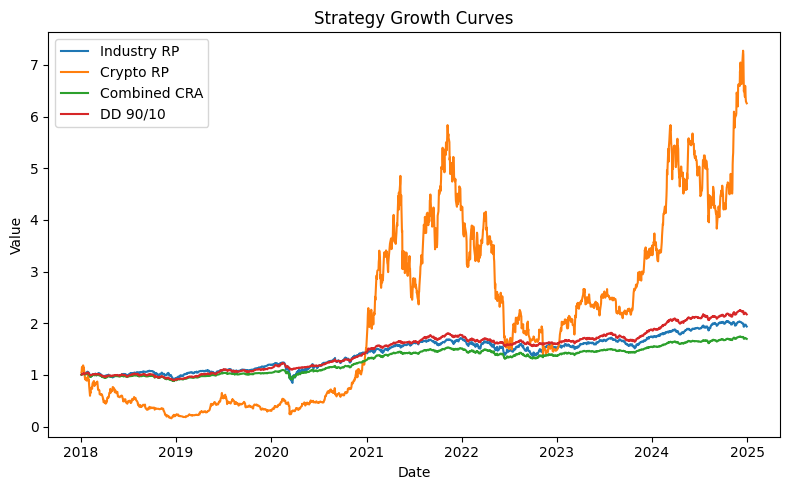

In [23]:
def compute_metrics(val):
    ret = val.pct_change().dropna()
    T = len(ret); days = 252
    final = val.iloc[-1]
    ann_ret = (final ** (days/T) - 1) * 100
    ann_vol = ret.std() * np.sqrt(days) * 100
    sharpe  = ann_ret / ann_vol
    drawdown= (val / val.cummax() - 1).min() * 100
    return ann_ret, ann_vol, sharpe, drawdown

# 1) Load value series
series = {
    "Industry RP": pd.read_csv("data/cleaned/industry_value.csv", parse_dates=["Date"], index_col="Date")["Value"],
    "Crypto RP":   pd.read_csv("data/cleaned/crypto_value.csv",   parse_dates=["Date"], index_col="Date")["Value"],
    "Combined CRA":pd.read_csv("data/cleaned/cra_value.csv",      parse_dates=["Date"], index_col="Date")["Value"],
    "DD 90/10":     pd.read_csv("data/cleaned/dd90_10_value.csv", parse_dates=["Date"], index_col="Date")["Value"],
}

# 2) Build summary
rows = []
for name, val in series.items():
    rows.append((name, *compute_metrics(val)))
summary = pd.DataFrame(rows, columns=[
    "Strategy","Ann Return (%)","Ann Vol (%)","Sharpe","Max Drawdown (%)"
]).set_index("Strategy")

print("\nPerformance Comparison (all start @1.0):")
print(summary.round(2))

# 3) Plot growth curves
plt.figure(figsize=(8,5))
for name, val in series.items():
    plt.plot(val.index, val, label=name)
plt.legend(); plt.title("Strategy Growth Curves"); plt.xlabel("Date"); plt.ylabel("Value")
plt.tight_layout()
plt.show()
